# 손동작 분류 경진대회

## 데이터 불러오기

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 15)

In [7]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/손동작-분류/Data/train.csv')
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/손동작-분류/Data/test.csv')

In [8]:
df.shape, test.shape

((2335, 34), (9343, 33))

In [9]:
df.drop('id', axis=1, inplace=True) ## id 컬럼 드랍
test.drop('id', axis=1, inplace=True) ## id 컬럼 드랍

## 센서 데이터를 이미지로 변환

In [10]:
df.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,...,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,-1.122174,-1.024673,-0.672769,-0.147724,-0.327494,-0.423462,0.676275,...,-0.081374,-0.370812,-0.726941,-0.809534,-0.495062,-0.743585,1.523340
std,11.486353,7.399859,26.519159,15.551500,11.461970,7.314322,26.869479,...,25.923355,15.541803,11.636507,7.469744,25.291238,16.300385,1.118221
min,-94.746969,-63.942094,-122.195138,-111.870691,-94.147972,-70.916786,-105.956553,...,-105.751637,-105.890010,-74.977182,-74.006065,-121.097086,-123.876153,0.000000
25%,-4.036597,-4.031957,-14.878500,-7.116633,-3.968687,-3.957699,-13.937806,...,-14.096840,-8.004561,-3.981055,-3.988965,-13.998874,-7.873898,1.000000
50%,-0.951398,-1.015582,-0.961088,-0.890469,-0.871690,-0.804810,0.058910,...,-0.954791,-0.989293,-0.889780,-0.928504,-0.955684,-1.019547,2.000000
75%,2.895540,2.140456,13.974075,6.110973,2.970387,3.006144,13.934438,...,13.903783,5.922250,2.972719,2.519426,13.926128,5.121679,3.000000
max,68.876142,39.913391,127.124171,102.015561,89.059852,34.923040,120.046277,...,123.179253,111.137925,54.098746,35.896503,125.974107,104.959621,3.000000


`-` 32개의 센서피쳐는 하나의 픽셀을 의미하는 것이 아닐까?(손동작 이미지를 32개의 픽셀로 나눈 것 같다; 아님말고)

`-` 0부근에 값이 많고 변수마다 분포가 유사함(종모양) 

`-` $8\times 4$ 배열로 변환하고 이를 확인해보자($4\times 8$로 해도 상관없을 듯)

`-` 위는 각 target의 sensor_1부터 sensor_32까지 각각의 평균이다

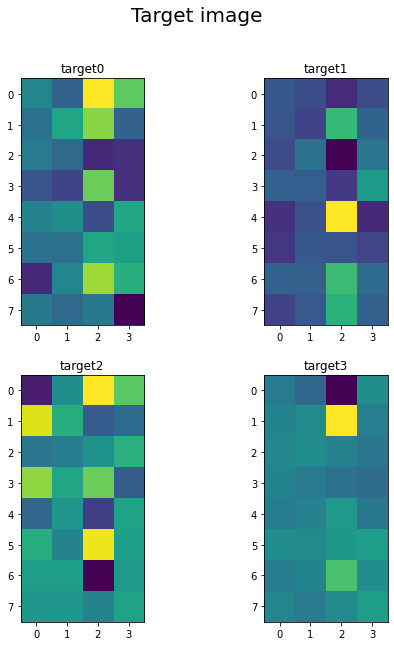

In [7]:
plt.figure(figsize=(8, 10))
for i in range(4) :
    plt.subplot(2, 2, i+1)
    plt.title(f'target{i}')
    plt.imshow(df.groupby('target').agg('mean').iloc[i,:].to_numpy().reshape(8, 4))
plt.suptitle('Target image', fontsize=20)
plt.show()

`-` 위의 4가지 그림을 보면 target마다 평균적으로 값의 차이가 있음을 알 수 있다

## CNN 설계 및 학습

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import StratifiedKFold

In [12]:
torch.manual_seed(22) ## 재현을 위한 seed 고정

`-` 일단 데이터를 정규화시켜주자(0부터 1까지)

`-` 값이 음수이면 활성화함수로 렐루를 취할 때 0이 되면서 노드가 죽어버린다(기울기 소멸)

In [13]:
target = df['target']
df.drop('target', axis=1, inplace=True)

In [14]:
X_df = (df + 130) / 260 ## 음수를 양수로 만들어주고 값을 0~1사이로 맞춰준다
X_test = (test + 130) / 260

In [15]:
X_df = torch.tensor(np.array(X_df).reshape(-1, 1, 8, 4), dtype=torch.float32) ## 1(흑백) * 8(높이) * 4(너비) 이미지가 -1(2335)개 존재함
X_test = torch.tensor(np.array(X_test).reshape(-1, 1, 8, 4), dtype=torch.float32)

In [16]:
print('min :', X_df.min(), '\nmax :', X_df.max())

min : tensor(0.0085) 
max : tensor(0.9891)


`-` 정규화가 잘 되었다

In [17]:
len(X_df)

2335

In [13]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(2, 1), padding='same'), ## padding='same' 옵션을 사용할려면 stride가 1이어야 한다
            ## 흑백이미지이므로 처음 인풋 채널은 1이다
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 2), padding='same'), ## 이미지가 직사각형(8*4) 모양이라 직사각형 커널 사용
            nn.ReLU(),
            #nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2)), ## 이미지 크기가 작으니 Pooling은 하지 않음
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=(2, 1), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 2), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AdaptiveAvgPool2d(1) ## Flatten역할 ## 이미지를 평균내서 1*1 크기로 만든다
        )
        
        self.linear_model = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4) ## softmax는 옵티마이저(CrossEntorpyLoss)에서 수행
        )

    def forward(self, x):
        x = self.cnn_model(x) ## shape: (N, 1, 8, 4) -> (N, 32, 1, 1) 
        x = x.squeeze() ## shape: (N, 32, 1, 1) -> (N, 32)
        x = self.linear_model(x) ## shape: (N, 32) -> (N, 4)
        return x

In [36]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 1)
        nn.init.constant_(m.bias.data, 0)

In [35]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [49]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, val_loss, val_acc, model):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt')
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 저장
        self.val_acc = val_acc ## 이때의 valid accuracy도 저장해준다

`-` 모델 앙상블

In [27]:
skfold = StratifiedKFold(n_splits=15, random_state=22, shuffle=True) ## 15겹 교차검증

In [36]:
save_path = 'C:/Users/Jaesu/github_desktop/Dacon-Basic/손동작-분류/손동작-분류-모델링/weight'
learning_rate = 0.005
epochs = 100
batch_size = 32
loss_fn = torch.nn.CrossEntropyLoss()   ## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨

In [37]:
## AVG_Pooling X
cnn_acc = [] ## fold별 valid셋의 평균 정확도
cnn_loss = [] ## fold별 valid셋의 평균 손실
n_fold = 0 ## 몇 번째 fold인지 check

for i, (train_idx, valid_idx) in enumerate(skfold.split(X_df, target)):
    print(f'{i + 1} Fold Training......')
    X_train, y_train = X_df[train_idx], target[train_idx]
    X_valid, y_valid = X_df[valid_idx], target[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    n_fold += 1
    early_stopping = EarlyStopping(patience=10,
                                     verbose=False,
                                     path=save_path,
                                     n_fold=n_fold) ## 10번의 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## CNN 모델
    net = CNN()
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    
    train_total_batch = len(train_dataloader) ## 배치 크기
    valid_total_batch = len(valid_dataloader)
    
    ## optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
    ## scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                                last_epoch=-1,
                                                verbose=False)
    
    ## fold별로 모델 학습
    net.train() ## 훈련모드
    for epoch in range(epochs): ## (배치사이즈 * 에폭)만큼 훈련시킴
        train_avg_loss, valid_avg_loss, valid_avg_acc = 0, 0, 0 ## 에폭별 배치단위 평균 훈련 오차와 평균 평가 오차와 valid accuracy

        for X, y in train_dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            optimizer.zero_grad() ## 그래디언트 초기화
            yhat = net(X) ## y_hat을 구한다
            loss = loss_fn(yhat, y) ## 오차를 계산 ## train loss
            loss.backward()  ## 미분
            optimizer.step() ## 업데이트
            train_avg_loss += (loss / train_total_batch) ## 각 배치마다 훈련 오차 누적
    
        ## epoch마다 학습률 조절
        scheduler.step()
    
        ## epoch마다 모델 평가
        net.eval() ## 평가모드
        for X, y in valid_dataloader: 
            with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
                yhat = net(X)
                loss = loss_fn(yhat, y) ## valid loss
                acc = accuracy(y.detach().numpy(), yhat.detach().numpy().argmax(-1))       
                valid_avg_acc += (acc * len(y) / len(valid_dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
                valid_avg_loss += loss / valid_total_batch ## 각 배치마다 평가 오차 누적                                                                  

        if epoch % 20 == 0 or epoch == epochs - 1: 
            ## 20의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(valid_avg_loss, valid_avg_acc, net) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 20 != 0 and epoch != epochs - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    cnn_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    cnn_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.5f}  Best Valid Accuracy: {early_stopping.val_acc:.5f}\n\n')
    
## 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실
print(f'{skfold.n_splits}Fold Mean Valid Accuracy: {np.mean(cnn_acc):.5f}')
print(f'{skfold.n_splits}Fold Mean Valid Loss: {np.mean(cnn_loss):.5f}')

1 Fold Training......
[Epoch:   1] train loss = 1.1752  valid loss = 0.78645
[Epoch:  21] train loss = 0.2075  valid loss = 0.4209
[Epoch:  23] train loss = 0.1853  valid loss = 0.45038
Early stopping!
1 Fold -> Best Valid Loss: 0.37015  Best Valid Accuracy: 0.86538


2 Fold Training......
[Epoch:   1] train loss = 1.179  valid loss = 1.35
[Epoch:  21] train loss = 0.25006  valid loss = 0.40409
[Epoch:  26] train loss = 0.15745  valid loss = 0.4094
Early stopping!
2 Fold -> Best Valid Loss: 0.38648  Best Valid Accuracy: 0.85897


3 Fold Training......
[Epoch:   1] train loss = 1.2226  valid loss = 0.9251
[Epoch:  21] train loss = 0.1331  valid loss = 0.53985
[Epoch:  29] train loss = 0.059399  valid loss = 0.55884
Early stopping!
3 Fold -> Best Valid Loss: 0.48124  Best Valid Accuracy: 0.85256


4 Fold Training......
[Epoch:   1] train loss = 1.1188  valid loss = 1.1323
[Epoch:  21] train loss = 0.17499  valid loss = 0.60583
[Epoch:  23] train loss = 0.13669  valid loss = 0.67554
Early

### test 예측

`-` softmax function을 취하면 4개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [38]:
weigh_path_list = glob(save_path + '/*.pt')
cnn_pred = torch.tensor(np.zeros((X_test.shape[0], 4))) ## test예측값

for weight in weigh_path_list :
    net.load_state_dict(torch.load(weight))
    net.eval()
    
    with torch.no_grad():
        outputs = net(X_test) ## shape -> (9343, 4)
        cnn_pred += outputs / 14  
        
_, pred = torch.max(cnn_pred, dim=1) ## 최대값과 인덱스를 반환
## return (value, indices), 1차원을 기준으로 max를 구한다
## 1차원을 기준으로 max를 구하므로 1차원을 없앤 9343개의 max가 반환된다
## 행별로 4개의 값 중 최대값을 리턴(총 9343개)
## 만약 dim=0으로 했다면 0번째 열~4번째 열별로 최대값을 구하므로 총 4개의 max값이 리턴됨

In [39]:
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/손동작-분류/Data/sample_submission.csv')

In [40]:
submission['target'] = pred
submission.head()

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2


In [104]:
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/손동작-분류/Data/submission5_15fold.csv', index=False)

## 센서 데이터 3D로 변환

`-` 센서 데이터는 손동작을 기록한 것이니까 3차원이지 않을까?(손은 3차원)

In [18]:
X_df = (df + 130) / 260 ## 음수를 양수로 만들어주고 값을 0~1사이로 맞춰준다
X_test = (test + 130) / 260

In [19]:
X_df = torch.tensor(np.array(X_df).reshape(-1, 1, 2, 4, 4), dtype=torch.float32) ## 1(흑백) * 2(깊이) * 4(세로) * 4(가로) 이미지가 -1(2335)개 존재함
X_test = torch.tensor(np.array(X_test).reshape(-1, 1, 2, 4, 4), dtype=torch.float32)

In [20]:
print('min :', X_df.min(), '\nmax :', X_df.max())

min : tensor(0.0085) 
max : tensor(0.9891)


In [37]:
class CNN3D(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv3d(in_channels=1, out_channels=8, kernel_size=(1, 1, 1), padding='same'), ## padding='same' 옵션을 사용할려면 stride가 1이어야 한다
            ## 흑백 3d 데이터이므로 처음 인풋 채널은 1이다
            nn.GELU(),
            nn.BatchNorm3d(8),
            nn.Conv3d(8, 16, kernel_size=(1, 2, 2), padding='same'), ## 센서가 직육면체 모양이여서 직육면체 커널을 사용
            nn.GELU(),
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 16, kernel_size=(2, 1, 1), padding='same'), ## 센서크기가 작아 커널 사이즈도 작은 것 사용
            nn.GELU(),
            nn.BatchNorm3d(16),
            nn.Conv3d(16, 8, kernel_size=(2, 1, 1), padding='same'),
            nn.GELU(),
            nn.BatchNorm3d(8),
            nn.Conv3d(8, 16, kernel_size=(2, 2, 2), padding='same'),
            nn.GELU(),
            nn.BatchNorm3d(16),
            nn.AdaptiveAvgPool3d(1) ## Flatten역할 ## 3d 센서 데이터값를 평균내서 1*1*1 크기로 만든다
        )
        
        self.linear_model = nn.Sequential(
            nn.Linear(16, 4) ## softmax는 옵티마이저(CrossEntorpyLoss)에서 수행
        )

    def forward(self, x):
        x = self.cnn_model(x) ## shape: (N, 1, 2, 4, 4) -> (N, 16, 1, 1, 1) 
        x = x.view(-1, 16) ## shape: (N, 16, 1, 1, 1) -> (N, 16)
        x = self.linear_model(x) ## shape: (N, 16) -> (N, 4)
        return x

In [38]:
skfold = StratifiedKFold(n_splits=15, random_state=22, shuffle=True) ## 15겹 교차검증

In [51]:
save_path = 'C:/Users/Jaesu/github_desktop/Dacon-Basic/손동작-분류/손동작-분류-모델링/weight'
learning_rate = 0.004
epochs = 100
batch_size = 32
loss_fn = torch.nn.CrossEntropyLoss()   ## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨

In [137]:
cnn_acc = [] ## fold별 valid셋의 평균 정확도
cnn_loss = [] ## fold별 valid셋의 평균 손실
n_fold = 0 ## 몇 번째 fold인지 check

for i, (train_idx, valid_idx) in enumerate(skfold.split(X_df, target)):
    print(f'{i + 1} Fold Training......')
    X_train, y_train = X_df[train_idx], target[train_idx]
    X_valid, y_valid = X_df[valid_idx], target[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    n_fold += 1
    early_stopping = EarlyStopping(patience=7,
                                     verbose=False,
                                     path=save_path,
                                     n_fold=n_fold) ## 7번의 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## CNN 모델
    net = CNN3D()
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    
    train_total_batch = len(train_dataloader) ## 배치 크기
    valid_total_batch = len(valid_dataloader)
    
    ## optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
    ## scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                                last_epoch=-1,
                                                verbose=False)
    
    ## fold별로 모델 학습
    net.train() ## 훈련모드
    for epoch in range(epochs): ## (배치사이즈 * 에폭)만큼 훈련시킴
        train_avg_loss, valid_avg_loss, valid_avg_acc = 0, 0, 0 ## 에폭별 배치단위 평균 훈련 오차와 평균 평가 오차와 valid accuracy

        for X, y in train_dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            optimizer.zero_grad() ## 그래디언트 초기화
            yhat = net(X) ## y_hat을 구한다
            loss = loss_fn(yhat, y) ## 오차를 계산 ## train loss
            loss.backward()  ## 미분
            optimizer.step() ## 업데이트
            train_avg_loss += (loss / train_total_batch) ## 각 배치마다 훈련 오차 누적
    
        ## epoch마다 학습률 조절
        scheduler.step()
    
        ## epoch마다 모델 평가
        net.eval() ## 평가모드
        for X, y in valid_dataloader: 
            with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
                yhat = net(X)
                loss = loss_fn(yhat, y) ## valid loss
                acc = accuracy(y.detach().numpy(), yhat.detach().numpy().argmax(-1))       
                valid_avg_acc += (acc * len(y) / len(valid_dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
                valid_avg_loss += loss / valid_total_batch ## 각 배치마다 평가 오차 누적                                                                  

        if epoch % 20 == 0 or epoch == epochs - 1: 
            ## 20의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(valid_avg_loss, valid_avg_acc, net) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 20 != 0 and epoch != epochs - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    cnn_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    cnn_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.5f}  Best Valid Accuracy: {early_stopping.val_acc:.5f}\n\n')
    
## 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실
print(f'{skfold.n_splits}Fold Mean Valid Accuracy: {np.mean(cnn_acc):.5f}')
print(f'{skfold.n_splits}Fold Mean Valid Loss: {np.mean(cnn_loss):.5f}')

1 Fold Training......
[Epoch:   1] train loss = 1.2301  valid loss = 1.3786
[Epoch:  21] train loss = 0.30206  valid loss = 0.46183
Early stopping!
1 Fold -> Best Valid Loss: 0.38337  Best Valid Accuracy: 0.83974


2 Fold Training......
[Epoch:   1] train loss = 1.0408  valid loss = 1.4324
[Epoch:  21] train loss = 0.32445  valid loss = 0.36753
[Epoch:  34] train loss = 0.24812  valid loss = 0.39354
Early stopping!
2 Fold -> Best Valid Loss: 0.35964  Best Valid Accuracy: 0.85256


3 Fold Training......
[Epoch:   1] train loss = 1.1717  valid loss = 1.2547
[Epoch:  19] train loss = 0.30232  valid loss = 0.45852
Early stopping!
3 Fold -> Best Valid Loss: 0.40105  Best Valid Accuracy: 0.85256


4 Fold Training......
[Epoch:   1] train loss = 1.1589  valid loss = 1.0986
[Epoch:  20] train loss = 0.28962  valid loss = 0.47615
Early stopping!
4 Fold -> Best Valid Loss: 0.45229  Best Valid Accuracy: 0.85256


5 Fold Training......
[Epoch:   1] train loss = 1.0769  valid loss = 1.0384
[Epoch: 

`-` softmax function을 취하면 4개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [139]:
weigh_path_list = glob(save_path + '/*.pt') ## *는 액셀에서의 *의미와 같다(임의 길이의 모든 문자열)
cnn_pred = torch.tensor(np.zeros((X_test.shape[0], 4))) ## test예측값

for weight in weigh_path_list :
    net.load_state_dict(torch.load(weight))
    net.eval()
    
    with torch.no_grad():
        outputs = net(X_test) ## shape -> (9343, 4)
        cnn_pred += outputs / 14  
        
_, pred = torch.max(cnn_pred, dim=1) ## 최대값과 인덱스를 반환
## return (value, indices), 1차원을 기준으로 max를 구한다
## 1차원을 기준으로 max를 구하므로 1차원을 없앤 9343개의 max가 반환된다
## 행별로 4개의 값 중 최대값을 리턴(총 9343개)
## 만약 dim=0으로 했다면 0번째 열~4번째 열별로 최대값을 구하므로 총 4개의 max값이 리턴됨

In [140]:
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/손동작-분류/Data/sample_submission.csv')

In [141]:
submission['target'] = pred
submission.head()

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2


In [142]:
submission.groupby('target').size()

target
0    2339
1    2385
2    2412
3    2207
dtype: int64

In [143]:
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/손동작-분류/Data/submission2_3d.csv', index=False)